In [1]:
import numpy as np
import numba as nb
import pylab as plt

njit = nb.njit
np.random.seed(0)

In [2]:
W0 = 1            # For easier computations - results are linear anyway in W0
r = 0.005         # taux livret A
m = 0.0463        # From get-mean-std-CAC40-after-outbreak.py output
sigma = 0.0313    # From get-mean-std-CAC40-after-outbreak.py output
S = 10000         # Number of Monte-Carlo simulations

In [3]:
@njit(nogil=True)
def compute_mu(m, sigma, S, set_seed = True):
    if set_seed: np.random.seed(0)
    mu = np.empty(S)
    for s in np.arange(S):
        mu[s] = m + sigma*np.random.normal()
    return mu

np.random.seed(0)
%time mu1 = compute_mu(m, sigma, S, set_seed = True)
%time mu2 = m + sigma*np.random.normal(size = S)

assert (mu1 == mu2).sum() == mu1.shape[0]

Wall time: 574 ms
Wall time: 0 ns


In [4]:
@njit(nogil = True)
def compute_actualized_wealth(W0, r, mu, phi, c):
    S, = mu.shape
    W = np.zeros(S)
    for s in np.arange(S):
        W[s] = np.maximum(0, W0 + (mu[s] - r)*np.minimum(phi, W0 - c)/(1 + r) - c)
    return W

In [5]:
phi = .5
c = .5
mu = compute_mu(m, sigma, S, set_seed = True)
%time W1 = np.maximum(0, W0 + (mu - r)*np.minimum(phi, W0 - c)/(1 + r) - c)
%time W2 = compute_actualized_wealth(W0, r, mu, phi, c)

assert (W1 == W2).sum() == W2.shape[0]

Wall time: 999 µs
Wall time: 160 ms


In [6]:
@njit(nogil = True)
def compute_profitability_probability(W0, W):
    S, = W.shape
    p = 0
    for s in np.arange(S):
        p += W[s] > W0/2
    return p/S

In [7]:
W = compute_actualized_wealth(W0, r, mu, phi, c)
%time p1 = (W > W0/2).mean()
%time p2 = compute_profitability_probability(W0, W)

assert p1 == p2

Wall time: 0 ns
Wall time: 140 ms


In [8]:
@njit(nogil = True)
def compute_profitability_probability_for_c(c, W0, r, mu, S, N_phi = 100):
    p = np.empty(N_phi + 1)
    W0_over_N_phi = W0/N_phi
    for n_phi in np.arange(N_phi + 1):
        phi = W0_over_N_phi*n_phi
        W  = compute_actualized_wealth(W0, r, mu, phi, c)
        p[n_phi]  = compute_profitability_probability(W0, W)
    return p

def compute_profitability_probability_for_c_no_jit(c, W0, r, mu, S, N_phi = 100):
    p = np.nan*np.ones(N_phi + 1)
    W0_over_N_phi = W0/N_phi
    for n_phi in np.arange(N_phi + 1):
        phi = W0_over_N_phi*n_phi
        if phi > (W0 - c): p[n_phi] = - 1
        W  = np.maximum(0, W0 + (mu - r)*np.minimum(phi, W0 - c)/(1 + r) - c)
        p[n_phi]  = (W > W0/2).mean()
    return p

In [9]:
mu = compute_mu(m, sigma, S)
S = 100

c = .5
%time p1 = compute_profitability_probability_for_c(c, W0, r, mu, S, N_phi = S)
%time p2 = compute_profitability_probability_for_c_no_jit(c, W0, r, mu, S, N_phi = S)

assert p1.sum() == p2.sum()

Wall time: 297 ms
Wall time: 15.6 ms


In [10]:
@njit(nogil = True)
def compute_profitability_probability_map(c, W0, r, m, sigma, S, N_phi = 100, N_c = 100):
    mu = compute_mu(m, sigma, S)
    p = np.empty((N_c + 1, N_phi + 1))
    c_over_N_c = W0/N_c
    for n_c in np.arange(N_c + 1):
        c = c_over_N_c*n_c
        p[n_c, :]  = compute_profitability_probability_for_c(c, W0, r, mu, S, N_phi = N_phi)
    return p


def compute_profitability_probability_map_no_jit(c, W0, r, m, sigma, S, N_phi = 100, N_c = 100):
    mu = compute_mu(m, sigma, S)
    p = np.empty((N_c + 1, N_phi + 1))
    c_over_N_c = W0/N_c
    for n_c in np.arange(N_c + 1):
        c = c_over_N_c*n_c
        p[n_c, :]  = compute_profitability_probability_for_c_no_jit(c, W0, r, mu, S, N_phi = N_phi)
    return p

In [24]:
%time p1 = compute_profitability_probability_map(c, W0, r, m, sigma, S, N_phi = 100, N_c = 100)
%time p2 = compute_profitability_probability_map_no_jit(c, W0, r, m, sigma, S, N_phi = 100, N_c = 100)

assert p1.sum() == p2.sum()

Wall time: 8.57 ms
Wall time: 182 ms


In [23]:
%time p = compute_profitability_probability_map(c, W0, r, m, sigma, S = 1000, N_phi = 5000, N_c = 5000)

Wall time: 39.8 s


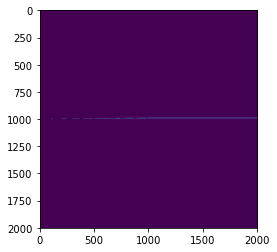

In [22]:
import pylab as plt
plt.imshow((p > .9409) & (p < 0.9501))